In [1]:
! eups list -s lsst_distrib

   21.0.0-2-g8e5b5ee+983633da53 	w_latest w_2021_16 current setup


```
git clone https://github.com/Snyder005/mixcoatl.git 
cd mixcoatl/
git checkout -t remotes/origin/u/alex-broughton/dm_gridfittask
```

In [2]:
import sys
sys.path.append("/gpfs/slac/lsst/fs1/g/data/youtsumi/Spot/mixcoatl/python")

In [3]:
import numpy
import pylab as plt

# Stack imports
from lsst.daf.butler import Butler
import lsst.afw.display as afwDisplay
import lsst.meas.extensions.shapeHSM
import lsst.afw.image as afwImage
from lsst.ip.isr.isrTask import IsrTask
from mixcoatl.characterizeSpots import CharacterizeSpotsTask
from mixcoatl.gridFitTask import GridFitTask

In [4]:
def display(exposure,title=None):
    afwDisplay.setDefaultBackend('matplotlib') 
    fig = plt.figure(figsize=(10,10))
    afw_display = afwDisplay.Display(1)
    afw_display.scale('asinh', 'zscale')
    afw_display.mtv(exposure.getImage())
    plt.title(title)
    plt.gca().axis('off')

In [5]:
repo_path = "/sdf/group/lsst/camera/IandT/repo_gen3/spot_test/butler.yaml"
butler = Butler(repo_path)

In [6]:
collections = 'LSSTCam/raw/all,u/echarles/calib/bias/run_12781'.split(",")
print(collections)
butler = Butler(repo_path,collections=collections)
registry = butler.registry

['LSSTCam/raw/all', 'u/echarles/calib/bias/run_12781']


2


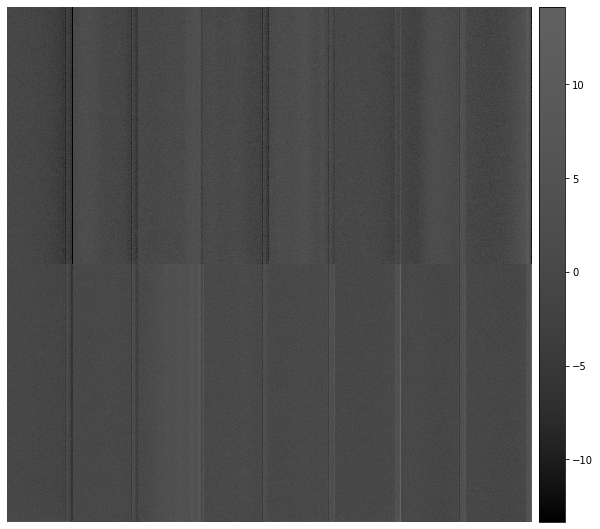

In [7]:
where = """
instrument='LSSTCam' and
detector=29 and
exposure.observation_type = 'spot' and
exposure.science_program IN ('12788') and
exposure.seq_num IN ( 1820, 1821  )
"""
atyp="bias"
datasetRefs = list(registry.queryDatasets(
    datasetType=atyp,collections=collections,
    where = where
))
print(len(datasetRefs))
bias = butler.get(datasetRefs[0])
display(bias)
plt.show()

/sdf/group/lsst/camera/IandT/repo_gen3/spot_test/LSSTCam/raw/all/raw/20201125/MC_C_20201125_001820/raw_LSSTCam_unknown_MC_C_20201125_001820_R10_S02_LSSTCam_raw_all.fits(MC_C_20201125_001820): Unable to determine the filter


{instrument: 'LSSTCam', detector: 29, exposure: 3020112501820, ...} / 2


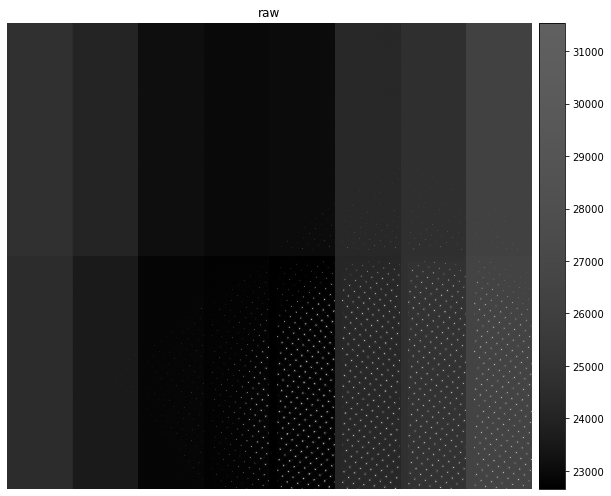

/sdf/group/lsst/camera/IandT/repo_gen3/spot_test/LSSTCam/raw/all/raw/20201125/MC_C_20201125_001821/raw_LSSTCam_unknown_MC_C_20201125_001821_R10_S02_LSSTCam_raw_all.fits(MC_C_20201125_001821): Unable to determine the filter


{instrument: 'LSSTCam', detector: 29, exposure: 3020112501821, ...} / 2


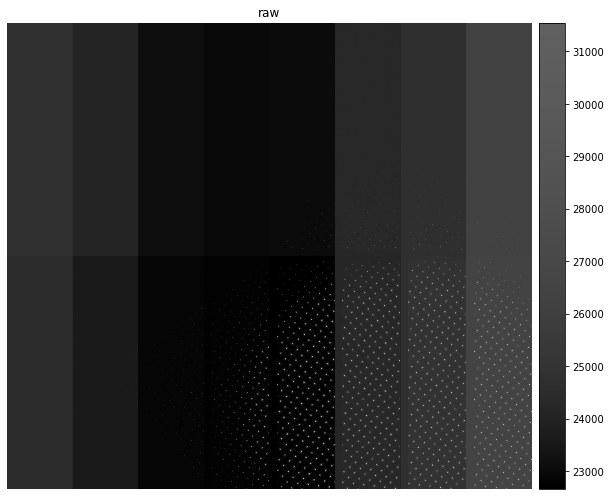

In [8]:
atyp = "raw"
datasetRefs = list(registry.queryDatasets(
    datasetType=atyp,collections=collections,
    where = where
))

raws = []
for i in range(len(datasetRefs)):
    print(datasetRefs[i].dataId, "/", len(datasetRefs))
    raw = butler.get(datasetRefs[i])
    raws.append(raw)
    display(raw,atyp)
    plt.show()


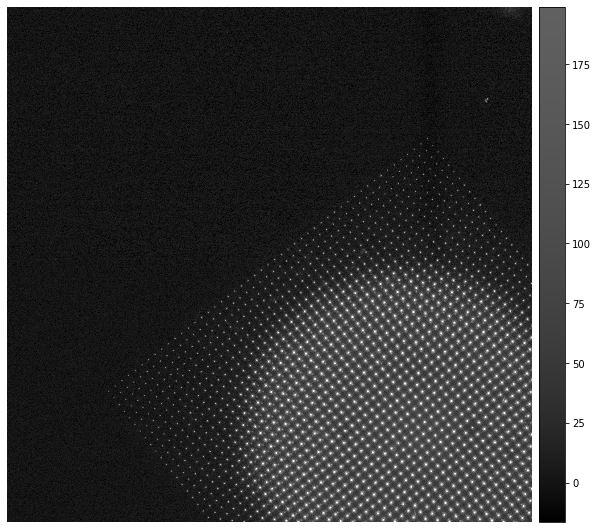

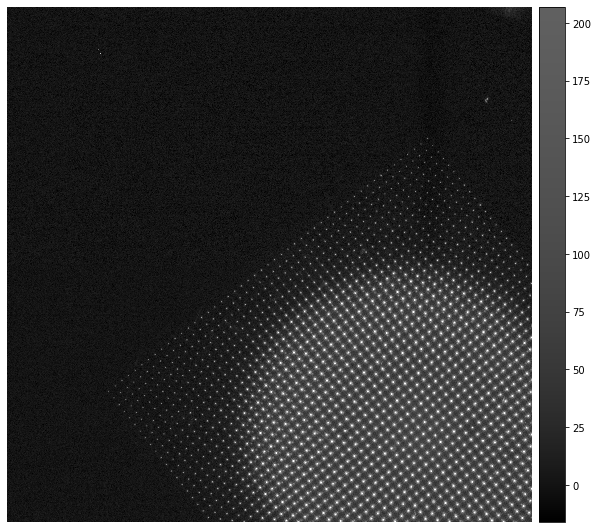

In [9]:
isr = IsrTask()
isr.config.doLinearize=False
isr.config.doDark=False
isr.config.doFlat=False
isr.config.doDefect=False
postISRarr = []
for raw in raws:
    postISRCCD = isr.run(raw,bias=bias)
    postISRarr.append(postISRCCD)
    display(postISRCCD.exposure)
    plt.show()

In [10]:
gridSourceArr = []
for postISRCCD in postISRarr:
    ## Run CharacterizeSpotsTask
    characterize = CharacterizeSpotsTask()
    #characterize.config.doMeasurePsf = False
    sourceCat = characterize.run(postISRCCD.exposure).sourceCat
    sourceCat = sourceCat.copy(deep=True)
    #sourceCat = characterize.run(postISRCCD.exposure).sourceCat
    ## Run GridFitTask
    gridfit = GridFitTask()
    gridSourceCat = gridfit.run(sourceCat, postISRCCD.exposure.getBBox()).gridSourceCat
    gridSourceArr.append(gridSourceCat)

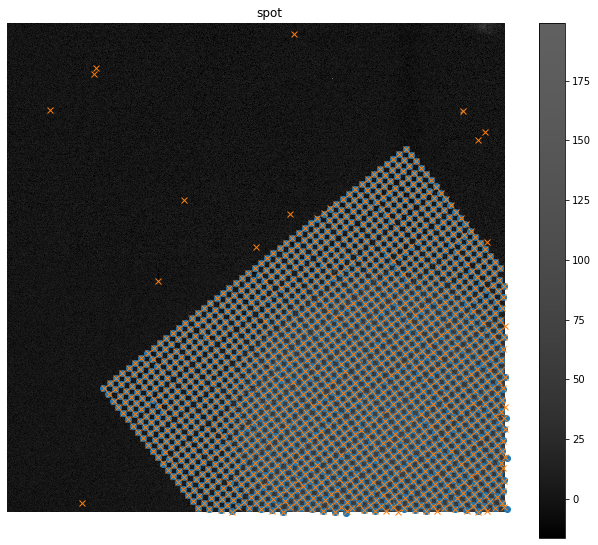

In [11]:
display(postISRarr[0].exposure)
for cat, x, y, sym in [
    (gridSourceCat, "spotgrid_x", "spotgrid_y", "o" ),
    (sourceCat, "base_SdssCentroid_x", "base_SdssCentroid_y", "x")
    ]:
    plt.title("spot")
    plt.plot(cat.asAstropy()[x],cat.asAstropy()[y],sym)


(0.0, 100.0)

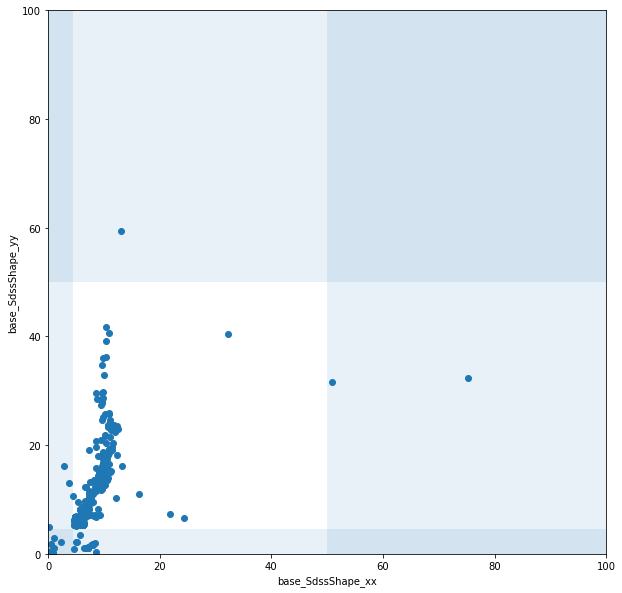

In [12]:
fig = plt.figure(figsize=(10,10))
plt.plot(sourceCat["base_SdssShape_xx"],sourceCat["base_SdssShape_yy"],"o")
plt.axvspan(0,4.5,alpha=0.1)
plt.axvspan(50,100,alpha=0.1)
plt.axhspan(0,4.5,alpha=0.1)
plt.axhspan(50,100,alpha=0.1)
plt.xlabel("base_SdssShape_xx")
plt.ylabel("base_SdssShape_yy")
plt.xlim(0,100)
plt.ylim(0,100)

In [13]:
gridSourceArr[0].asAstropy()

id,coord_ra,coord_dec,parent,base_SdssCentroid_x,base_SdssCentroid_y,base_SdssCentroid_xErr,base_SdssCentroid_yErr,base_SdssCentroid_flag,base_SdssCentroid_flag_edge,base_SdssCentroid_flag_noSecondDerivative,base_SdssCentroid_flag_almostNoSecondDerivative,base_SdssCentroid_flag_notAtMaximum,base_SdssCentroid_flag_resetToPeak,base_SdssCentroid_flag_badError,base_SdssShape_xx,base_SdssShape_yy,base_SdssShape_xy,base_SdssShape_xxErr,base_SdssShape_yyErr,base_SdssShape_xyErr,base_SdssShape_x,base_SdssShape_y,base_SdssShape_instFlux,base_SdssShape_instFluxErr,base_SdssShape_psf_xx,base_SdssShape_psf_yy,base_SdssShape_psf_xy,base_SdssShape_instFlux_xx_Cov,base_SdssShape_instFlux_yy_Cov,base_SdssShape_instFlux_xy_Cov,base_SdssShape_flag,base_SdssShape_flag_unweightedBad,base_SdssShape_flag_unweighted,base_SdssShape_flag_shift,base_SdssShape_flag_maxIter,base_SdssShape_flag_psf,ext_shapeHSM_HsmPsfMoments_x,ext_shapeHSM_HsmPsfMoments_y,ext_shapeHSM_HsmPsfMoments_xx,ext_shapeHSM_HsmPsfMoments_yy,ext_shapeHSM_HsmPsfMoments_xy,ext_shapeHSM_HsmPsfMoments_flag,ext_shapeHSM_HsmPsfMoments_flag_no_pixels,ext_shapeHSM_HsmPsfMoments_flag_not_contained,ext_shapeHSM_HsmPsfMoments_flag_parent_source,ext_shapeHSM_HsmPsfMoments_flag_galsim,ext_shapeHSM_HsmPsfMoments_flag_edge,ext_shapeHSM_HsmShapeBj_e1,ext_shapeHSM_HsmShapeBj_e2,ext_shapeHSM_HsmShapeBj_sigma,ext_shapeHSM_HsmShapeBj_resolution,ext_shapeHSM_HsmShapeBj_flag,ext_shapeHSM_HsmShapeBj_flag_no_pixels,ext_shapeHSM_HsmShapeBj_flag_not_contained,ext_shapeHSM_HsmShapeBj_flag_parent_source,ext_shapeHSM_HsmShapeBj_flag_galsim,ext_shapeHSM_HsmShapeKsb_g1,ext_shapeHSM_HsmShapeKsb_g2,ext_shapeHSM_HsmShapeKsb_sigma,ext_shapeHSM_HsmShapeKsb_resolution,ext_shapeHSM_HsmShapeKsb_flag,ext_shapeHSM_HsmShapeKsb_flag_no_pixels,ext_shapeHSM_HsmShapeKsb_flag_not_contained,ext_shapeHSM_HsmShapeKsb_flag_parent_source,ext_shapeHSM_HsmShapeKsb_flag_galsim,ext_shapeHSM_HsmShapeLinear_e1,ext_shapeHSM_HsmShapeLinear_e2,ext_shapeHSM_HsmShapeLinear_sigma,ext_shapeHSM_HsmShapeLinear_resolution,ext_shapeHSM_HsmShapeLinear_flag,ext_shapeHSM_HsmShapeLinear_flag_no_pixels,ext_shapeHSM_HsmShapeLinear_flag_not_contained,ext_shapeHSM_HsmShapeLinear_flag_parent_source,ext_shapeHSM_HsmShapeLinear_flag_galsim,ext_shapeHSM_HsmShapeRegauss_e1,ext_shapeHSM_HsmShapeRegauss_e2,ext_shapeHSM_HsmShapeRegauss_sigma,ext_shapeHSM_HsmShapeRegauss_resolution,ext_shapeHSM_HsmShapeRegauss_flag,ext_shapeHSM_HsmShapeRegauss_flag_no_pixels,ext_shapeHSM_HsmShapeRegauss_flag_not_contained,ext_shapeHSM_HsmShapeRegauss_flag_parent_source,ext_shapeHSM_HsmShapeRegauss_flag_galsim,ext_shapeHSM_HsmSourceMoments_x,ext_shapeHSM_HsmSourceMoments_y,ext_shapeHSM_HsmSourceMoments_xx,ext_shapeHSM_HsmSourceMoments_yy,ext_shapeHSM_HsmSourceMoments_xy,ext_shapeHSM_HsmSourceMoments_flag,ext_shapeHSM_HsmSourceMoments_flag_no_pixels,ext_shapeHSM_HsmSourceMoments_flag_not_contained,ext_shapeHSM_HsmSourceMoments_flag_parent_source,ext_shapeHSM_HsmSourceMoments_flag_galsim,ext_shapeHSM_HsmSourceMoments_flag_edge,base_CircularApertureFlux_3_0_instFlux,base_CircularApertureFlux_3_0_instFluxErr,base_CircularApertureFlux_3_0_flag,base_CircularApertureFlux_3_0_flag_apertureTruncated,base_CircularApertureFlux_3_0_flag_sincCoeffsTruncated,base_CircularApertureFlux_4_5_instFlux,base_CircularApertureFlux_4_5_instFluxErr,base_CircularApertureFlux_4_5_flag,base_CircularApertureFlux_4_5_flag_apertureTruncated,base_CircularApertureFlux_4_5_flag_sincCoeffsTruncated,base_CircularApertureFlux_6_0_instFlux,base_CircularApertureFlux_6_0_instFluxErr,base_CircularApertureFlux_6_0_flag,base_CircularApertureFlux_6_0_flag_apertureTruncated,base_CircularApertureFlux_6_0_flag_sincCoeffsTruncated,base_CircularApertureFlux_9_0_instFlux,base_CircularApertureFlux_9_0_instFluxErr,base_CircularApertureFlux_9_0_flag,base_CircularApertureFlux_9_0_flag_apertureTruncated,base_CircularApertureFlux_9_0_flag_sincCoeffsTruncated,base_CircularApertureFlux_12_0_instFlux,base_CircularApertureFlux_12_0_instFluxErr

In [14]:
from astropy.table import join
joined = join(gridSourceArr[0].asAstropy(),gridSourceArr[1].asAstropy(),keys=["spotgrid_index"])

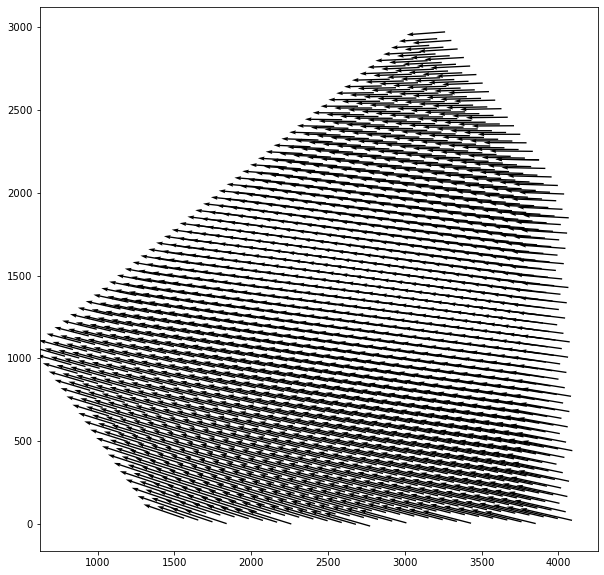

In [22]:
scale =10
fig = plt.figure(figsize=(10,10))
plt.quiver(
    joined["spotgrid_x_1"],
    joined["spotgrid_y_1"],
    (joined["spotgrid_x_2"]-joined["spotgrid_x_1"]),
    (joined["spotgrid_y_2"]-joined["spotgrid_y_1"]),
    scale = scale,
    angles = "xy",
#    width = .1
)